In [1]:
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from pandas.tools.plotting import scatter_matrix
%matplotlib inline

In [5]:
data = pd.read_csv("../../Data/WeatherOutagesAll_RK.csv")

In [8]:
data.head()

,Total_outages,Day_length_hr,Avg_Temp_F,Avg_humidity_percent,Max_windspeed_mph,Avg_windspeed_mph,Max_windgust_mph,Precipitation_in,outage_class
0,0,12.783333,58,89,8,2,9,0.01,0.0
1,2,12.716667,62,69,8,4,9,0.00,0.0
2,1,12.666667,64,74,16,7,25,0.00,0.0
3,0,12.616667,71,66,17,12,9,0.00,0.0
4,1,12.550000,66,79,12,5,9,0.00,0.0


In [7]:
for i in range(data.shape[0]):
    if data.iloc[i].Total_outages < 3:
        data.loc[i, "outage_class"] = int(0)
    elif data.iloc[i].Total_outages > 7:
        data.loc[i, "outage_class"] = int(2)
    else:
        data.loc[i, "outage_class"] = int(1)

In [34]:
scaler = StandardScaler()

In [35]:
#grid search
xTrain = None
yTrain = None
xTest = None
yTest = None
df = None

for train, test in splitter.split(data):
    xTrain = scaler.fit_transform(data.iloc[train, 1:-1])
    yTrain = data.iloc[train, -1]
    xTest = scaler.transform(data.iloc[test, 1:-1])
    yTest = data.iloc[test, -1]
    cRange = np.logspace(-3, 3, 7)
    gammaRange = np.logspace(-3, 3, 7)
    paramGrid = dict(gamma=gammaRange, C=cRange)
    grid = GridSearchCV(SVC(cache_size=1000.0, verbose=1, class_weight="balanced"),
                        param_grid=paramGrid, cv=KFold(n_splits=5, shuffle=True), verbose=True)
    grid.fit(xTrain, yTrain)
    print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))
    df = pd.DataFrame(grid.cv_results_)
    df.to_csv("resultsRBF1.csv")

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][L

[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:  6.8min finished


[LibSVM]The best parameters are {'C': 1.0, 'gamma': 100.0} with a score of 0.88


Need a metric to correctly predict class 1 and 2

In [65]:
xTrain = None
yTrain = None
xTest = None
yTest = None
nSplits = 10
kfold = KFold(n_splits=nSplits, shuffle=True)
shuffleSplitter = ShuffleSplit(n_splits=nSplits, test_size=0.2)
classifier = SVC(C=100, gamma=0.1, cache_size=1000.0, class_weight="balanced", probability=True)

df = pd.DataFrame()
for cValue in np.logspace(-5, 5, 11):
    for gammaValue in np.logspace(-5, 5, 11):
        classifier.set_params(C = cValue, gamma = gammaValue)
        allCorrectness = []
        allFalseNegativesBad = []
        allFalseNegativesExtreme = []
        allFalsePositives = []
        allBadDays = []
        allExtremeDays = []
        
        for train, test in shuffleSplitter.split(data):
            overallCorrectness = 0
            falseNegativesBad = 0
            falseNegativesExtreme = 0
            falsePositives = 0
            badDays = 0
            extremeDays = 0
            xTrain = scaler.fit_transform(data.iloc[train, 1:-1])
            yTrain = data.iloc[train, -1]
            xTest = scaler.transform(data.iloc[test, 1:-1])
            yTest = data.iloc[test, -1]
            classifier.fit(xTrain, yTrain)
            yPredict = classifier.predict(xTest)
            yTest = yTest.tolist()
            yPredict = yPredict.tolist()
            for i in range(len(yTest)):
                if yTest[i] == 1:
                    badDays += 1
                elif yTest[i] == 2:
                    extremeDays += 1
                if yTest[i] == yPredict[i]:
                    overallCorrectness += 1
                elif yTest[i] < yPredict[i]:
                    falsePositives += 1
                elif yTest[i] == 1 and yPredict[i] == 0:
                    falseNegativesBad += 1
                else: # yTest[i] == 2 and yPredict[i] != 2
                    falseNegativesExtreme += 1
            allCorrectness.append(overallCorrectness / len(yTest))
            allBadDays.append(badDays)
            allExtremeDays.append(extremeDays)
            if badDays != 0:
                allFalseNegativesBad.append(falseNegativesBad / badDays)
                allFalsePositives.append(falsePositives / (badDays + extremeDays))
            else:
                allFalseNegativesBad.append(0)
                allFalsePositives.append(0)
            if extremeDays != 0:
                allFalseNegativesExtreme.append(falseNegativesExtreme / extremeDays)
            else:
                allFalseNegativesExtreme.append(0)
            
        df = df.append({"C": cValue, "gamma": gammaValue, "Overall_Correctness": np.mean(allCorrectness),
                         "False_Negatives_Extreme": np.mean(allFalseNegativesExtreme),
                        "False_Negatives_Bad": np.mean(allFalseNegativesBad),
                        "False_Positives": np.mean(allFalsePositives),
                       "Bad_Days": np.mean(allbadDays),
                        "Extreme_Days": np.mean(allExtremeDays)}, ignore_index = True)
df.to_csv("gridSearch2.csv")

,Bad_Days,C,Extreme_Days,False_Negatives_Bad,False_Negatives_Extreme,False_Positives,Overall_Correctness,gamma
0,135.2,0.00001,14.1,0.300000,0.500000,5.745204,0.293027,0.00001
1,135.2,0.00001,13.7,0.600000,0.800000,3.308781,0.552162,0.00010
2,135.2,0.00001,14.4,0.500000,0.900000,3.901914,0.481995,0.00100
3,135.2,0.00001,14.5,0.300000,0.800000,5.427809,0.323036,0.01000
4,135.2,0.00001,13.3,0.800000,1.000000,1.530679,0.728332,0.10000
5,135.2,0.00001,13.3,0.600000,0.700000,3.746154,0.542277,1.00000
6,135.2,0.00001,13.8,0.600000,0.800000,3.387290,0.552780,10.00000
7,135.2,0.00001,13.7,0.400000,0.700000,4.776159,0.390733,100.00000
8,135.2,0.00001,11.9,0.900000,1.000000,0.686806,0.806708,1000.00000
9,135.2,0.00001,14.1,0.700000,0.900000,2.389249,0.641483,10000.00000


In [56]:
xTrain = None
yTrain = None
scaler = StandardScaler()
classifier = SVC(C=10, gamma=0.01, class_weight="balanced", probability=True)

xTrain = scaler.fit_transform(data.iloc[:, 1:-1])
yTrain = data.iloc[:, -1]
classifier.fit(xTrain, yTrain)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [82]:
from sklearn.externals import joblib
joblib.dump(classifier, 'SVCmodel.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [12]:
from sklearn.externals import joblib
classifier = joblib.load("SVCmodel.pkl")
scaler = joblib.load("scaler.pkl")
bar = np.array([[12,70,80,8,5,10,0.]])
bar = bar.reshape(1,-1)
bar2 = scaler.transform(bar)
print(classifier.predict(bar2))
classifier.predict_proba(bar2)

[ 0.]


array([[ 0.96614198,  0.03266029,  0.00119773]])

In [13]:
def predictOutage(weatherData):
    if weatherData.shape[1] != 7:
        raise ValueError("7 features are required. See documentation.")
    model = joblib.load("SVCmodel.pkl")
    scaler = joblib.load("scaler.pkl")
    scaledData = scaler.transform(weatherData)
    return model.predict_proba(weatherData)

In [7]:
from sklearn.externals import joblib
bar = np.array([[12,70,80,8,5,10,0.]])
def predictOutageProba(weatherData):
    if weatherData.shape[1] != 7:
        raise ValueError("7 features are required. See documentation.")
    model = joblib.load("SVCmodel.pkl")
    scaler = joblib.load("scaler.pkl")
    scaledData = scaler.transform(weatherData)
    return model.predict_proba(scaledData)
predictOutageProba(bar)

array([[ 0.96614198,  0.03266029,  0.00119773]])

Plot data distribution

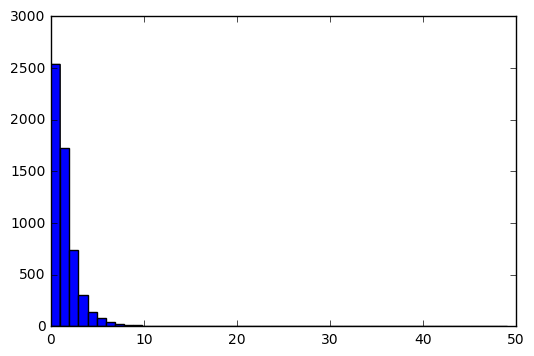

In [101]:
plt.hist(data.Total_outages, bins=50)
plt.show()